# Data source (QALD-9) 
https://github.com/KGQA/QALD_9_plus 

Since the LC-QuAD 2.0 dataset caused two major problems, 
- the first one being that the queries for dbpedia are not working because of the format from dbpedia18 which by that time included wikidata links and 
- the second one being that the wikidata endpoint is not able to execute queries with qualifiers

A new dataset is used to test the wikidata adn DBpedia endpoints. The QALD-9 dataset is used to test the endpoints.

In [1]:
# import all the necessary libraries
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter

Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitA

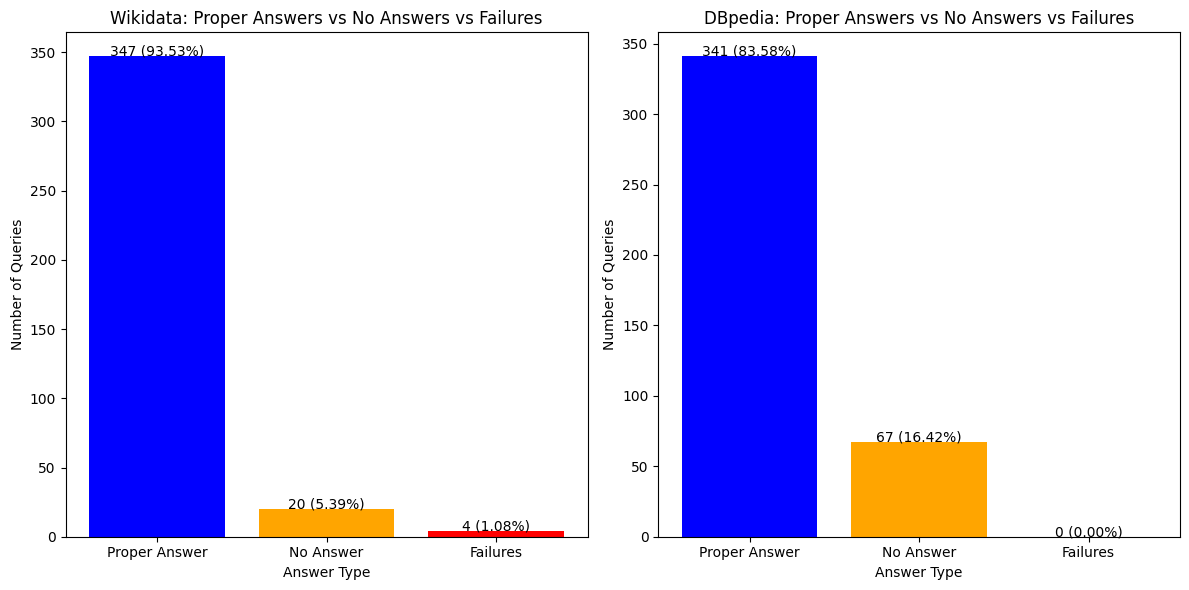

In [2]:
# Load new QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize counters and results list
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for both datasets
process_queries(wikidata_questions, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(dbpedia_questions, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qald9_test_results_split.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]
colors = ['blue', 'orange', 'red']

ax1.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

plt.tight_layout()
plt.show()

Executing all queries from the QALD-9 dataset with the official endpoints being https://query.wikidata.org/sparql and "https://dbpedia.org/sparql" it can be seen that most of the queries are working. While a bit less aren't working for DBpedia.

## Check Skynet (Local Wikidata) endpoint
Checking the skynet endpoint to see if the queries are working and if the endpoint is able to return results when hosted locally.

Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'Parse error: Variable used when already in-scope: ?uri in ((AGG ?.0 COUNT(DISTINCT ?uri)) AS ?uri)\n'
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation timed out
Query failed: The read operation ti

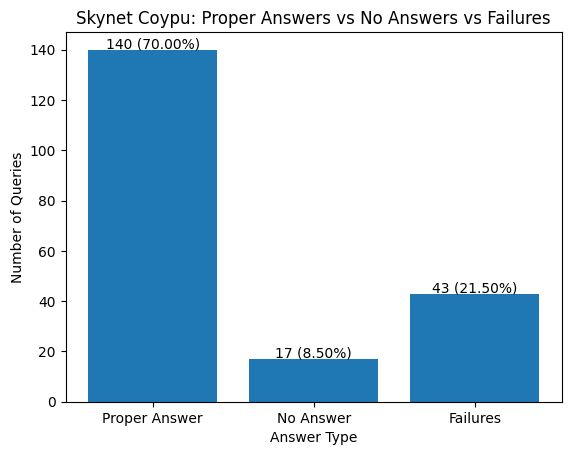

In [3]:
# Load new QALD-9 datasets for Wikidata
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
wikidata_data = requests.get(wikidata_url).json()

# Define SPARQL endpoints
SKYNET_COYPU_WIKIDATA_ENDPOINT = "https://skynet.coypu.org/wikidata/"

# Define prefixes for the Skynet Coypu endpoint
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to add prefixes to the SPARQL query
def add_prefixes(sparql_query):
    return PREFIXES + sparql_query

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from Wikidata dataset
wikidata_questions = extract_questions(wikidata_data, language="en")[:200]

# Initialize counters and results list
skynet_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
skynet_results = []

# Function to execute queries with prefixes for Skynet Coypu endpoint
def process_skynet_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            # Add prefixes to the query for Skynet Coypu
            query_with_prefixes = add_prefixes(sparql_query)
            result = query_sparql(endpoint, query_with_prefixes)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only first 10 queries for Skynet Coypu
process_skynet_queries(wikidata_questions, SKYNET_COYPU_WIKIDATA_ENDPOINT, skynet_results, skynet_counts)

# Calculate percentages for Skynet Coypu
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

skynet_proper_pct, skynet_no_pct, skynet_failure_pct = calculate_percentages(skynet_counts)

# Print counts and percentages for Skynet Coypu results
print("Skynet Coypu Results:")
print(f"Proper answers: {skynet_counts['proper_answer']} ({skynet_proper_pct:.2f}%)")
print(f"No answers: {skynet_counts['no_answer']} ({skynet_no_pct:.2f}%)")
print(f"Failures: {skynet_counts['failure']} ({skynet_failure_pct:.2f}%)\n")

# Save Skynet results to an Excel file
skynet_df = pd.DataFrame(skynet_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("skynet_test_results.xlsx") as writer:
    skynet_df.to_excel(writer, sheet_name="Skynet Coypu Results", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [skynet_counts["proper_answer"], skynet_counts["no_answer"], skynet_counts["failure"]]

plt.bar(labels, sizes)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.5, f"{sizes[i]} ({[skynet_proper_pct, skynet_no_pct, skynet_failure_pct][i]:.2f}%)", ha='center')

plt.title('Skynet Coypu: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.show()

Taking a look at the results from the queries executed with the skynet endpoint https://skynet.coypu.org/wikidata/, it can be seen that most of the queries are working and returning results. However there are significantly more queries which are not working compared to the official wikidata endpoint. Furthermore the runtime is significantly higher taking 55min to execute 200 queries, compared to 7min with the official wikidata endpoint. 

## Check queries with qualifiers only (Wikidata Query Service)
The following check is done to see if the wikidata queries including "qualifiers" are working properly. Since the qulifiers are an important part of wikidata and are one major difference to dbpedia, it is important to see if the queries are working, for the further evaluation and translation of the queries. To check that all queries with qualifiers are executed for poth endpoints.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b"SPARQL-QUERY: queryStr=PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/> PREFIX pq: <http://www.wikidata.org/prop/qualifier/> PREFIX ps: <http://www.wikidata.org/prop/statement/> PREFIX p: <http://www.wikidata.org/prop/>  SELECT ?res WHERE { ?res p:P39 _:a . _:a ps:P39 wd:Q22575092 . :a pq:P580 ?start . } ORDER BY DESC(?start) LIMIT 1\njava.util.concurrent.ExecutionException: org.openrdf.query.MalformedQueryException: com.bigdata.rdf.sail.sparql.ast.VisitorException: QName ':a' uses an undefined prefix\n\tat java.util.concurrent.FutureTask.report(FutureTask.java:122)\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:206)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.big

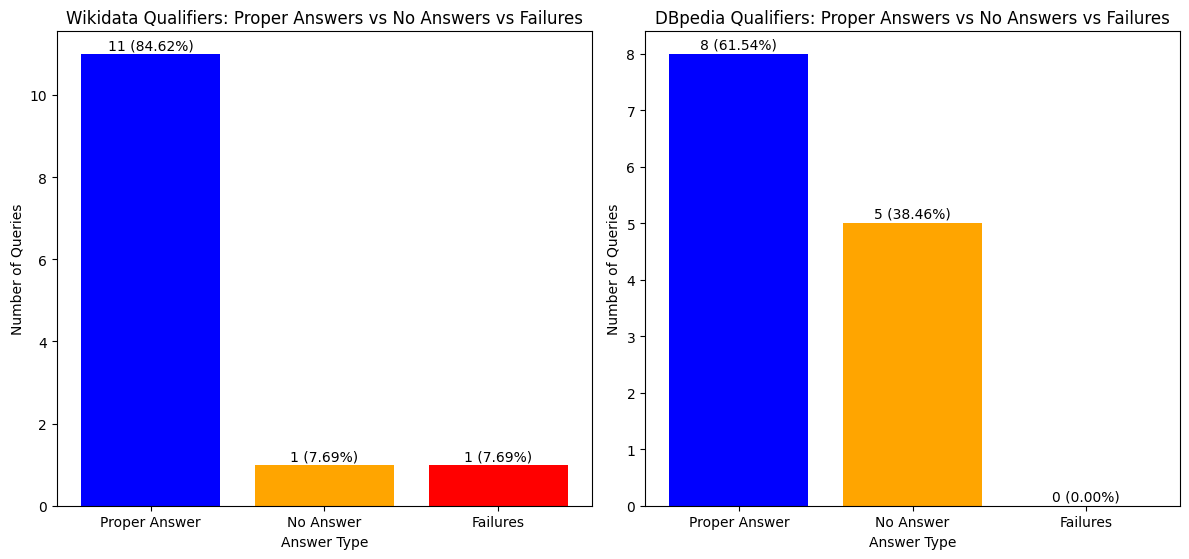

In [4]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "https://dbpedia.org/sparql"

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Extract Wikidata questions with qualifiers and corresponding DBpedia questions
def extract_qualified_questions(wikidata_data, dbpedia_data):
    qualified_wikidata = []
    qualified_dbpedia = []

    # Filter Wikidata questions containing "pq:" in the SPARQL query
    wikidata_qualifiers = [
        q for q in wikidata_data["questions"]
        if "pq:" in q["query"]["sparql"]
    ]

    # Match each Wikidata question with its corresponding DBpedia question using "id"
    for entry in wikidata_qualifiers:
        question_id = entry["id"]
        wikidata_question_data = {
            "id": question_id,
            "question": next((q["string"] for q in entry["question"] if q["language"] == "en"), None),
            "sparql": entry["query"]["sparql"]
        }
        qualified_wikidata.append(wikidata_question_data)

        # Find the matching DBpedia question
        dbpedia_entry = next((q for q in dbpedia_data["questions"] if q["id"] == question_id), None)
        if dbpedia_entry:
            dbpedia_question_data = {
                "id": question_id,
                "question": next((q["string"] for q in dbpedia_entry["question"] if q["language"] == "en"), None),
                "sparql": dbpedia_entry["query"]["sparql"]
            }
            qualified_dbpedia.append(dbpedia_question_data)

    return qualified_wikidata, qualified_dbpedia

# Get qualified questions for both Wikidata and DBpedia
qualified_wikidata, qualified_dbpedia = extract_qualified_questions(wikidata_data, dbpedia_data)

# Initialize counters and results lists
wikidata_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
wikidata_results = []
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process qualified queries for both Wikidata and DBpedia
process_queries(qualified_wikidata, WIKIDATA_ENDPOINT, wikidata_results, wikidata_counts)
process_queries(qualified_dbpedia, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for each dataset
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct = calculate_percentages(wikidata_counts)
dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages
print("Wikidata Results:")
print(f"Proper answers: {wikidata_counts['proper_answer']} ({wikidata_proper_pct:.2f}%)")
print(f"No answers: {wikidata_counts['no_answer']} ({wikidata_no_pct:.2f}%)")
print(f"Failures: {wikidata_counts['failure']} ({wikidata_failure_pct:.2f}%)\n")

print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Combine results and save to Excel
wikidata_df = pd.DataFrame(wikidata_results, columns=['Question', 'ID', 'Result', 'Answer'])
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("qualifiers_qald9_results.xlsx") as writer:
    wikidata_df.to_excel(writer, sheet_name="Wikidata Results", index=False)
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with separate bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Wikidata chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [wikidata_counts["proper_answer"], wikidata_counts["no_answer"], wikidata_counts["failure"]]

ax1.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax1.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[wikidata_proper_pct, wikidata_no_pct, wikidata_failure_pct][i]:.2f}%)", ha='center')

ax1.set_title('Wikidata Qualifiers: Proper Answers vs No Answers vs Failures')
ax1.set_ylabel('Number of Queries')
ax1.set_xlabel('Answer Type')

# DBpedia chart
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

ax2.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    ax2.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

ax2.set_title('DBpedia Qualifiers: Proper Answers vs No Answers vs Failures')
ax2.set_ylabel('Number of Queries')
ax2.set_xlabel('Answer Type')

# Adjust layout to provide more space for the titles
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave extra space at the top for titles
plt.show()


## DBpedia Test for local endpoint
Checking the local dbpedia endpoint hosted on clever to see if the queries are also working locally and if there is a difference in the results compared to the official dbpedia endpoint.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"COUNT\\": extraneous input \'COUNT\' expecting {\'*\', \'(\', DISTINCT, REDUCED, VAR1, VAR2}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 7,\n        "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n        "startIndex": 7,\n        "stopIndex": 11\n    },\n    "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid

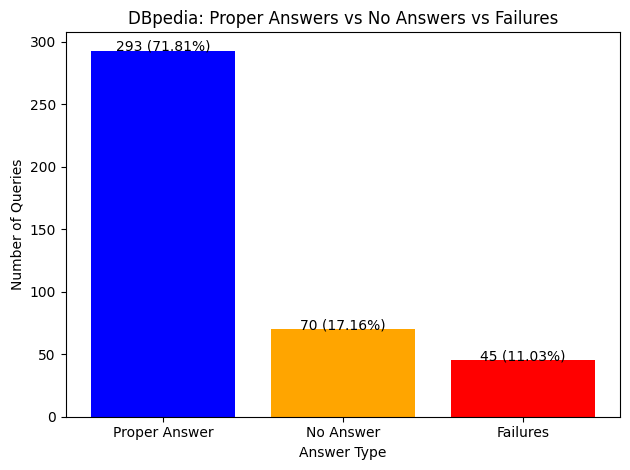

In [ ]:
# Load QALD-9 dataset for DBpedia
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoint for local DBpedia
DBPEDIA_ENDPOINT = "http://localhost:7012/sparql"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare the first 10 questions from DBpedia dataset
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize counters and results list for DBpedia
dbpedia_counts = {"proper_answer": 0, "no_answer": 0, "failure": 0}
dbpedia_results = []

# Function to execute queries and process answers
def process_queries(questions, endpoint, results_list, counts_dict):
    for entry in questions:
        sparql_query = entry.get('sparql')
        question = entry.get('question')
        
        if sparql_query:
            result = query_sparql(endpoint, sparql_query)
            if result:
                answer = extract_answer(result)
                if "No answer" in answer:
                    counts_dict["no_answer"] += 1
                else:
                    counts_dict["proper_answer"] += 1
                results_list.append((question, entry["id"], 'Success', answer))
            else:
                counts_dict["failure"] += 1
                results_list.append((question, entry["id"], 'Failure', ['No answer']))

# Process only the first 10 DBpedia queries
process_queries(dbpedia_questions, DBPEDIA_ENDPOINT, dbpedia_results, dbpedia_counts)

# Calculate percentages for DBpedia results
def calculate_percentages(counts):
    total = counts["proper_answer"] + counts["no_answer"] + counts["failure"]
    proper_answer_pct = (counts["proper_answer"] / total) * 100 if total > 0 else 0
    no_answer_pct = (counts["no_answer"] / total) * 100 if total > 0 else 0
    failure_pct = (counts["failure"] / total) * 100 if total > 0 else 0
    return proper_answer_pct, no_answer_pct, failure_pct

dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct = calculate_percentages(dbpedia_counts)

# Print counts and percentages for DBpedia
print("DBpedia Results:")
print(f"Proper answers: {dbpedia_counts['proper_answer']} ({dbpedia_proper_pct:.2f}%)")
print(f"No answers: {dbpedia_counts['no_answer']} ({dbpedia_no_pct:.2f}%)")
print(f"Failures: {dbpedia_counts['failure']} ({dbpedia_failure_pct:.2f}%)\n")

# Save DBpedia results to an Excel file
dbpedia_df = pd.DataFrame(dbpedia_results, columns=['Question', 'ID', 'Result', 'Answer'])

with pd.ExcelWriter("dbpedia_test_results_local.xlsx") as writer:
    dbpedia_df.to_excel(writer, sheet_name="DBpedia Results", index=False)

# Visualize the results with a bar chart
labels = ['Proper Answer', 'No Answer', 'Failures']
sizes = [dbpedia_counts["proper_answer"], dbpedia_counts["no_answer"], dbpedia_counts["failure"]]

plt.bar(labels, sizes, color=colors)
for i in range(len(labels)):
    plt.text(i, sizes[i] + 0.1, f"{sizes[i]} ({[dbpedia_proper_pct, dbpedia_no_pct, dbpedia_failure_pct][i]:.2f}%)", ha='center')

plt.title('DBpedia: Proper Answers vs No Answers vs Failures')
plt.ylabel('Number of Queries')
plt.xlabel('Answer Type')
plt.tight_layout()
plt.show()

## Building working dataset for Wikidata and DBpedia
After checking the queries from the QALD-9 dataset, it can be seen that the queries are working for both endpoints. Now the goal is to create a new dataset which includes only the queries which are working for both endpoints.

In [7]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for Wikidata and local DBpedia
WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"
DBPEDIA_ENDPOINT = "http://localhost:7012/sparql"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    sparql.addCustomHttpHeader("User-Agent", "QALDQueryTool/1.0 (contact@example.com)")

    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from both Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize a list to store questions that work on both endpoints
common_successful_queries = []

# Function to execute queries and check if they return a proper answer
def is_proper_answer(endpoint, sparql_query):
    result = query_sparql(endpoint, sparql_query)
    if result:
        answer = extract_answer(result)
        return "No answer" not in answer  # Return True if it has a proper answer
    return False

# Process and filter questions with proper answers on both Wikidata and DBpedia
for wikidata_entry in wikidata_questions:
    dbpedia_entry = next((q for q in dbpedia_questions if q["id"] == wikidata_entry["id"]), None)
    if dbpedia_entry:
        wikidata_query_success = is_proper_answer(WIKIDATA_ENDPOINT, wikidata_entry["sparql"])
        dbpedia_query_success = is_proper_answer(DBPEDIA_ENDPOINT, dbpedia_entry["sparql"])
        
        if wikidata_query_success and dbpedia_query_success:
            # Store successful queries for both endpoints
            common_successful_queries.append({
                "id": wikidata_entry["id"],
                "question": wikidata_entry["question"],
                "wikidata_sparql": wikidata_entry["sparql"],
                "dbpedia_sparql": dbpedia_entry["sparql"]
            })

# Calculate the percentage of successful queries on both endpoints
total_queries = min(len(wikidata_questions), len(dbpedia_questions))  # Total queries available in both datasets
successful_queries_count = len(common_successful_queries)
success_percentage = (successful_queries_count / total_queries) * 100 if total_queries > 0 else 0

# Create a DataFrame for the common successful queries
successful_queries_df = pd.DataFrame(common_successful_queries)

# Save the successful queries to a new Excel file
successful_queries_df.to_excel("common_successful_queries.xlsx", index=False)

# Print summary
print(f"Total questions in the dataset: {total_queries}")
print(f"Total questions with proper answers on both endpoints: {successful_queries_count}")
print(f"Percentage of successful queries on both endpoints: {success_percentage:.2f}%")

Query failed: The read operation timed out
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"COUNT\\": extraneous input \'COUNT\' expecting {\'*\', \'(\', DISTINCT, REDUCED, VAR1, VAR2}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 7,\n        "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n        "startIndex": 7,\n        "stopIndex": 11\n    },\n    "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 1,\n        "total": 1\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed.

## Test for both local enpoints on wikidata as well as DBpedia

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"COUNT\\": extraneous input \'COUNT\' expecting {\'*\', \'(\', DISTINCT, REDUCED, VAR1, VAR2}",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 7,\n        "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n        "startIndex": 7,\n        "stopIndex": 11\n    },\n    "query": "SELECT COUNT(DISTINCT ?uri AS ?uri) WHERE { ?uri <http://dbpedia.org/ontology/director> <http://dbpedia.org/resource/Park_Chan-wook> . }",\n    "resultsize": 0,\n    "status": "ERROR",\n    "time": {\n        "computeResult": 3,\n        "total": 3\n    }\n}'
Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid

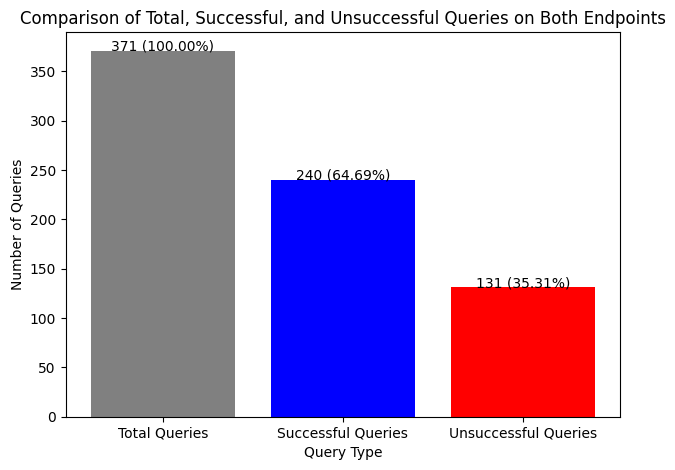

In [ ]:
# Load QALD-9 datasets for Wikidata and DBpedia
wikidata_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_wikidata.json"
dbpedia_url = "https://raw.githubusercontent.com/KGQA/QALD_9_plus/refs/heads/main/data/qald_9_plus_train_dbpedia.json"

wikidata_data = requests.get(wikidata_url).json()
dbpedia_data = requests.get(dbpedia_url).json()

# Define SPARQL endpoints for local Wikidata and DBpedia
WIKIDATA_ENDPOINT = "http://localhost:7001"  # Local Wikidata endpoint
DBPEDIA_ENDPOINT = "http://localhost:7012"  # Local DBpedia endpoint

# Function to query SPARQL endpoint with User-Agent and handle bytes response
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits
    
    try:
        return sparql.query().convert()  # Return results for further processing
    except Exception as e:
        print(f"Query failed: {e}")
        return None  # Query failed

# Extract the answer from SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Helper function to extract English questions and IDs from QALD-9 format
def extract_questions(dataset, language="en"):
    questions = []
    for entry in dataset["questions"]:
        question_data = next((q for q in entry["question"] if q["language"] == language), None)
        if question_data:
            questions.append({
                "id": entry["id"],
                "question": question_data["string"],
                "sparql": entry["query"]["sparql"]
            })
    return questions

# Prepare questions from both Wikidata and DBpedia datasets
wikidata_questions = extract_questions(wikidata_data, language="en")
dbpedia_questions = extract_questions(dbpedia_data, language="en")

# Initialize a list to store questions that work on both endpoints
common_successful_queries = []

# Function to execute queries and check if they return a proper answer
def is_proper_answer(endpoint, sparql_query):
    result = query_sparql(endpoint, sparql_query)
    if result:
        answer = extract_answer(result)
        return "No answer" not in answer  # Return True if it has a proper answer
    return False

# Process and filter questions with proper answers on both Wikidata and DBpedia
for wikidata_entry in wikidata_questions:
    dbpedia_entry = next((q for q in dbpedia_questions if q["id"] == wikidata_entry["id"]), None)
    if dbpedia_entry:
        wikidata_query_success = is_proper_answer(WIKIDATA_ENDPOINT, wikidata_entry["sparql"])
        dbpedia_query_success = is_proper_answer(DBPEDIA_ENDPOINT, dbpedia_entry["sparql"])
        
        if wikidata_query_success and dbpedia_query_success:
            # Store successful queries for both endpoints
            common_successful_queries.append({
                "id": wikidata_entry["id"],
                "question": wikidata_entry["question"],
                "wikidata_sparql": wikidata_entry["sparql"],
                "dbpedia_sparql": dbpedia_entry["sparql"]
            })

# Calculate the percentage of successful and unsuccessful queries
total_queries = min(len(wikidata_questions), len(dbpedia_questions))  # Total queries available in both datasets
successful_queries_count = len(common_successful_queries)
unsuccessful_queries_count = total_queries - successful_queries_count  # Total minus successful
success_percentage = (successful_queries_count / total_queries) * 100 if total_queries > 0 else 0
unsuccess_percentage = 100 - success_percentage

# Create a DataFrame for the common successful queries
successful_queries_df = pd.DataFrame(common_successful_queries)

# Save the successful queries to a new Excel file
successful_queries_df.to_excel("common_successful_queries_local_endpoints.xlsx", index=False)

# Print summary
print(f"Total questions in the dataset: {total_queries}")
print(f"Total questions with proper answers on both endpoints: {successful_queries_count}")
print(f"Total questions with unsuccessful answers on both endpoints: {unsuccessful_queries_count}")
print(f"Percentage of successful queries on both endpoints: {success_percentage:.2f}%")

# Visualize the results in a bar chart
labels = ['Total Queries', 'Successful Queries', 'Unsuccessful Queries']
sizes = [total_queries, successful_queries_count, unsuccessful_queries_count]
percentages = [100, success_percentage, unsuccess_percentage]
colors = ['grey', 'blue', 'red']

plt.bar(labels, sizes, color=colors)
for i, (size, pct) in enumerate(zip(sizes, percentages)):
    plt.text(i, size + 0.1, f"{size} ({pct:.2f}%)", ha='center')
plt.title('Comparison of Total, Successful, and Unsuccessful Queries on Both Endpoints')
plt.ylabel('Number of Queries')
plt.xlabel('Query Type')
plt.tight_layout()
plt.show()


## Create Dataset with the successful queries only 

In [9]:
# Create the new dataset structure with only successful queries
successful_dataset = {
    "questions": [
        {
            "id": entry["id"],
            "question": [{"language": "en", "string": entry["question"]}],
            "query": {
                "sparql_wikidata": entry["wikidata_sparql"],
                "sparql_dbpedia": entry["dbpedia_sparql"]
            }
        }
        for entry in common_successful_queries
    ]
}

# Save to a new JSON file
with open("successful_queries_qald9.json", "w") as json_file:
    json.dump(successful_dataset, json_file, indent=4)

print("New dataset with successful queries saved as 'successful_queries_qald9.json'")


New dataset with successful queries saved as 'successful_queries_qald9.json'


This script is designed to process SPARQL queries from the QALD-9 dataset, extracting entities and relations from DBpedia and finding their equivalent mappings in Wikidata. It also handles duplicate removal and outputs the results in a structured format for further analysis. Below is a detailed explanation of the purpose and functionality of the code.

---

## **Purpose**

1. **Mapping DBpedia Entities to Wikidata**:
   - The goal is to identify equivalent entities and relations in Wikidata using predefined equivalence properties from DBpedia entries.

2. **Dataset**:
   - The script uses the dataset of 240 successful SPARQL queries (`successful_queries_qald9.json`), which are verified to work on both DBpedia and Wikidata endpoints.

3. **Exclude List**:
   - An exclude list (`exclude_items`) filters out query prefixes in DBpedia that are not directly translatable to Wikidata (e.g., prefixes like `dbo:` or `rdf:type` etc.).

4. **Output**:
   - The results are saved into:
     - `mapped_entities_relations.json`: Contains mappings of DBpedia entities to Wikidata equivalents.
     - `removed_duplicates.json`: Logs duplicate entries for further analysis.

---

## **Code Workflow**

### 1. **Setup**
**Query Template**:
  - A SPARQL query template (`DBPEDIA_EQUIVALENT_QUERY_TEMPLATE`) is used to identify equivalent properties in DBpedia entries which are translatable to other knowledge graphs, such as `owl:sameAs`, `owl:equivalentProperty`, and `owl:equivalentClass`.
  - Only links containing `http://www.wikidata.org/` are retained to exclude relations to other KGs like Geonames or Freebase.

### 2. **Prefix Expansion**
- Function: `expand_prefix(identifier)`: Converts prefixed DBpedia terms (e.g., `dbo:` or `res:`) into full URIs using a predefined mapping (`DBPEDIA_PREFIXES`).

### 3. **Extracting Entities and Relations**
- Function: `extract_entities_relations(query)`: Extracts entities and relations from the `sparql_dbpedia` queries using regular expressions and removes unwanted characters such as `<`, `>`, and trailing `>.`, which are included in the syntax of the DBpedia query.

### 4. **Finding Equivalent Entities in Wikidata**
- Function: `get_wikidata_equivalents(dbpedia_id)`: Queries the DBpedia SPARQL endpoint to find equivalent entities in Wikidata using OWL properties and filters results to include only those pointing to Wikidata URLs.

### 5. **Processing Queries**
For each query in the dataset:
**Entities and Relations Extraction**:
- Entities and relations are extracted and cleaned.
**Equivalence Mapping**:
- For each extracted DBpedia entity, equivalent entities in Wikidata are identified.
**Duplicate Removal**:
- Duplicates are tracked using a `seen_dbpedia_ids` set.
- If a duplicate is detected, it is logged and excluded from the results.
- **Result Structuring**:
Each processed query is structured into a dictionary containing:
- `question_id`: Unique identifier for the query.
- `question`: The natural language question.
- `dbpedia_query`: The original DBpedia SPARQL query.
- `mapped_entities_relations`: Mappings of DBpedia entities to Wikidata equivalents.

In [10]:
# Exclude list with exact matching
exclude_items = {
    "http://dbpedia.org/ontology/", "dbo:", "http://dbpedia.org/resource/", "res:",
    "rdf:", "http://www.w3.org/1999/02/22-rdf-syntax-ns#", "rdf:type",
    "dbr:", "dbp:", "rdfs:", "http://www.w3.org/2000/01/rdf-schema#",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type", "http://dbpedia.org/property/",
    "yago:", "http://dbpedia.org/class/yago/", "http://dbpedia.org/ontology/type",
    "onto:", "dbo:type", "skos:", "http://www.w3.org/2004/02/skos/core#",
    "dbc:", "dct:"
}

# Load the dataset
with open("successful_queries_qald9.json", "r") as file:
    dbpedia_data = json.load(file)["questions"]

# SPARQL endpoint for DBpedia
DBPEDIA_ENDPOINT = "http://localhost:7012"  # Local DBpedia endpoint

# SPARQL query template to find equivalent links for a DBpedia entity
DBPEDIA_EQUIVALENT_QUERY_TEMPLATE = """
SELECT ?wikidataEquivalent WHERE {{
    {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#sameAs> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#equivalentProperty> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#equivalentClass> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#sameIndividualAs> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#differentFrom> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#AllDifferent> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#disjointWith> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#inverseOf> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#Ontology> ?wikidataEquivalent .
    }} UNION {{
        <{dbpedia_entity}> <http://www.w3.org/2002/07/owl#Restriction> ?wikidataEquivalent .
    }}
    FILTER STRSTARTS(STR(?wikidataEquivalent), "http://www.wikidata.org/")
}}
"""

# Mapping of prefixes to namespaces
DBPEDIA_PREFIXES = {
    "dbo": "http://dbpedia.org/ontology/",
    "res": "http://dbpedia.org/resource/",
    "yago": "http://dbpedia.org/class/yago/",
    "onto": "http://dbpedia.org/ontology/",
    "dbp": "http://dbpedia.org/property/",
    "dbr": "http://dbpedia.org/resource/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    "dbc": "http://dbpedia.org/resource/Category:",
    "dct": "http://purl.org/dc/terms/"
}

# Initialize SPARQL wrapper for DBpedia
dbpedia_sparql = SPARQLWrapper(DBPEDIA_ENDPOINT)

def expand_prefix(identifier):
    """
    Expand prefixed entities and relations into full URIs.
    """
    if ":" in identifier:
        prefix, local_name = identifier.split(":", 1)
        if prefix in DBPEDIA_PREFIXES:
            return f"{DBPEDIA_PREFIXES[prefix]}{local_name}"
    return identifier

def extract_entities_relations(query):
    """
    Extract entities and relations from the SPARQL query.
    """
    # Matches full URIs and prefixed entities/relations
    entity_relation_pattern = r"<([^>]+)>|(\w+:[^\s,;]*)"
    matches = re.findall(entity_relation_pattern, query)
    extracted_ids = [match[0] if match[0] else expand_prefix(match[1]) for match in matches]
    print(f"Extracted entities/relations: {extracted_ids}")
    return extracted_ids

def get_wikidata_equivalents(dbpedia_id):
    """
    Query DBpedia for equivalent Wikidata entities.
    """
    wikidata_equivalents = []
    query = DBPEDIA_EQUIVALENT_QUERY_TEMPLATE.format(dbpedia_entity=dbpedia_id)
    dbpedia_sparql.setQuery(query)
    dbpedia_sparql.setReturnFormat(JSON)
    try:
        results = dbpedia_sparql.query().convert()
        equivalents = [
            result["wikidataEquivalent"]["value"]
            for result in results["results"]["bindings"]
        ]
        wikidata_equivalents.extend(equivalents)
    except Exception as e:
        print(f"Error querying for {dbpedia_id}: {e}")
    return list(set(wikidata_equivalents))

# Process the queries
mapped_entities_relations = []
total_duplicates_removed = 0
removed_duplicates = []

for entry in dbpedia_data:
    dbpedia_query = entry["query"]["sparql_dbpedia"]
    extracted_ids = extract_entities_relations(dbpedia_query)

    er2 = {"entities_relations": []}
    seen_dbpedia_ids = set()  # Track unique dbpedia_ids for duplicates

    for dbpedia_id in extracted_ids:
        # Skip if dbpedia_id is in exclude list
        if dbpedia_id in exclude_items:
            continue

        # Retrieve equivalents from DBpedia
        wikidata_ids = get_wikidata_equivalents(dbpedia_id)

        # Check for duplicates
        if dbpedia_id not in seen_dbpedia_ids:
            er2["entities_relations"].append({
                "dbpedia_id": dbpedia_id,
                "wikidata_ids": wikidata_ids
            })
            seen_dbpedia_ids.add(dbpedia_id)
        else:
            total_duplicates_removed += 1
            removed_duplicates.append({
                "question_id": entry["id"],
                "dbpedia_id": dbpedia_id,
                "wikidata_ids": wikidata_ids
            })

    mapped_entities_relations.append({
        "question_id": entry["id"],
        "question": entry["question"][0]["string"],
        "dbpedia_query": dbpedia_query,
        "mapped_entities_relations": er2
    })

# Save the results to a JSON file
with open("mapped_entities_relations.json", "w") as file:
    json.dump(mapped_entities_relations, file, indent=4)

# Save the removed duplicates to a separate file
with open("removed_duplicates.json", "w") as file:
    json.dump(removed_duplicates, file, indent=4)

# Output summary
print("Mappings saved to 'mapped_entities_relations.json'.")
print(f"Total duplicates removed: {total_duplicates_removed}")
print(f"Details of removed duplicates saved to 'removed_duplicates.json'.")


Extracted entities/relations: ['http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/resource/', 'http://dbpedia.org/resource/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'http://dbpedia.org/ontology/publisher', 'http://dbpedia.org/resource/GMT_Games']
Extracted entities/relations: ['http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/resource/', 'http://dbpedia.org/resource/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'http://dbpedia.org/resource/Skype', 'http://dbpedia.org/ontology/developer']
Extracted entities/relations: ['http://dbpedia.org/class/yago/', 'http://dbpedia.org/class/yago/', 'rdfs:', 'http://www.w3.org/2000/01/rdf-schema#', 'rdf:', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#', 'http://dbpedia.org/ontology/', 'http://dbpedia.org/ontology/', 'rdf:type', 'http://dbpedia.org/ontology/Person', 'http://dbpedia.org/ontology/birthPlace', 'http://dbpedia.org/resource/Heraklion']
Extracted entities/re

## Analysis of the Results
- In general 637 DBpedia entities/relations got detected, while 493 could successfully be mapped to Wikidata, 144 could not be mapped.

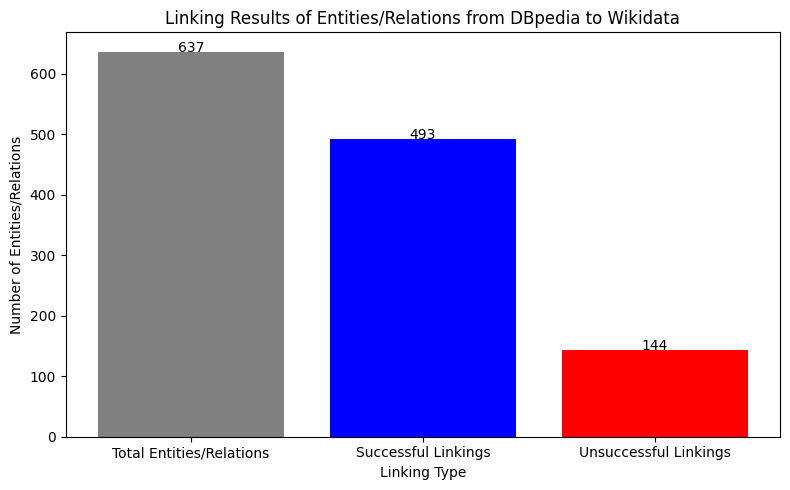

In [11]:
# Load the results from the JSON file (adjust the file path if necessary)
with open("mapped_entities_relations.json", "r") as file:
    mapped_entities_relations = json.load(file)

# Count successful linkings
total_entities_relations = 0
successful_linkings = 0

for entry in mapped_entities_relations:
    for er in entry["mapped_entities_relations"]["entities_relations"]:
        total_entities_relations += 1
        if er["wikidata_ids"]:  # Count if there's at least one valid Wikidata ID
            successful_linkings += 1

# Calculate unsuccessful linkings
unsuccessful_linkings = total_entities_relations - successful_linkings

# Plot the results
labels = ['Total Entities/Relations', 'Successful Linkings', 'Unsuccessful Linkings']
sizes = [total_entities_relations, successful_linkings, unsuccessful_linkings]
colors = ['grey', 'blue', 'red']

plt.figure(figsize=(8, 5))
plt.bar(labels, sizes, color=colors)
for i, size in enumerate(sizes):
    plt.text(i, size + 0.1, f"{size}", ha='center')
plt.title('Linking Results of Entities/Relations from DBpedia to Wikidata')
plt.ylabel('Number of Entities/Relations')
plt.xlabel('Linking Type')
plt.tight_layout()
plt.show()

## Find unsuccessful mappings
In order to find the unsuccessful mappings, the empty mappings are extracted and saved in a separate file. In general there are 112 questions with unmapped entities/relations. There are two possible reasons for the unmapped entities/relations:
- The entities/relations are not present in Wikidata.
- The entities/relations are present in Wikidata but are not linked to the corresponding DBpedia entities/relations.

In order to get the better insights into the empty mappings the 112 questions are checked manuall, to see if the entities/relations are present in Wikidata or not.

In [12]:
# Load the dataset
with open("mapped_entities_relations.json", "r") as file:
    data = json.load(file)

# Collect entries where "wikidata_ids" is empty
unmapped_entries = []

for entry in data:
    unmapped_entities = [
        entity for entity in entry["mapped_entities_relations"]["entities_relations"]
        if not entity["wikidata_ids"]  # Check if "wikidata_ids" is empty
    ]
    if unmapped_entities:  # Only include if there are unmapped entities
        unmapped_entries.append({
            "question_id": entry["question_id"],
            "question": entry["question"],
            "dbpedia_query": entry["dbpedia_query"],
            "unmapped_entities": unmapped_entities
        })

# Save the unmapped entries to a JSON file
with open("unmapped_entities.json", "w") as file:
    json.dump(unmapped_entries, file, indent=4)

print(f"Found {len(unmapped_entries)} questions with unmapped entities.")
print("Results saved to 'unmapped_entities.json'.")

Found 112 questions with unmapped entities.
Results saved to 'unmapped_entities.json'.


In [13]:
# Load the JSON data from the file
with open("unmapped_entities.json", "r") as file:
    json_data = json.load(file)

# Convert JSON data into a pandas DataFrame
data = []
for entry in json_data:
    for entity in entry["unmapped_entities"]:
        data.append({
            "question_id": entry["question_id"],
            "question": entry["question"],
            "dbpedia_query": entry["dbpedia_query"],
            "dbpedia_id": entity["dbpedia_id"],
            "wikidata_ids": ", ".join(entity["wikidata_ids"]) if entity["wikidata_ids"] else ""
        })

df = pd.DataFrame(data)

# Save to an Excel file
df.to_excel("unmapped_entities_output.xlsx", index=False)

print("File saved as 'unmapped_entities_output.xlsx'")


File saved as 'unmapped_entities_output.xlsx'


After manually checking the empty mappings, three further mappings could be found, which were not found by the script. The other 144 mappings are not present in Wikidata.

Thoughts for better mapping: 
- Sometimes property/... does not have a direct mapping to Wikidata, but ontology/... has a mapping. Could this be a solution? 
- Give more hints for the mapping, when there is no direct mapping, e.g. give more of the information which is provided in the DBpedia entry, e.g. rdfs lables (domain, label, range, ...)

## Analyis of frequency in mapped entities and relations
In the following the frequency of the mapped entities and relations is analyzed, highlighting the most frequently linked entities. The results are used to understand patterns in entity mapping and provide a summary of `dbpedia_id` usage, and make them comparable to extraction from the original dataset (later in this scriped). In total there are 393 unique entities, while the entities "starring" and "country" appear most frequently, with 17 mappings each.


In [14]:
# Load the JSON dataset
with open("mapped_entities_relations.json", "r") as file:
    mapped_entities_relations = json.load(file)

# Counter for dbpedia_id occurrences
dbpedia_id_counter = Counter()

# Process each entry in the dataset
for entry in mapped_entities_relations:
    entities_relations = entry["mapped_entities_relations"]["entities_relations"]
    for entity_relation in entities_relations:
        dbpedia_id = entity_relation["dbpedia_id"]
        dbpedia_id_counter[dbpedia_id] += 1

# Calculate the total count
total_count = sum(dbpedia_id_counter.values())

# Sort by occurrences in descending order
sorted_dbpedia_ids = sorted(dbpedia_id_counter.items(), key=lambda x: x[1], reverse=True)

# Output the results
print(f"Total unique dbpedia_id entries: {len(dbpedia_id_counter)}")
print(f"Total occurrences of all dbpedia_id entries: {total_count}")
print("Unique dbpedia_id entries with their counts (sorted by count, descending):")
for dbpedia_id, count in sorted_dbpedia_ids:
    print(f"{dbpedia_id}: {count}")

# Save the results to a JSON file
output_data = {
    "unique_count": len(dbpedia_id_counter),
    "total_count": total_count,
    "dbpedia_ids": dict(sorted_dbpedia_ids)
}

with open("dbpedia_id_summary.json", "w") as file:
    json.dump(output_data, file, indent=4)

print("Results saved to 'dbpedia_id_summary.json'.")

Total unique dbpedia_id entries: 393
Total occurrences of all dbpedia_id entries: 637
Unique dbpedia_id entries with their counts (sorted by count, descending):
http://dbpedia.org/ontology/starring: 17
http://dbpedia.org/ontology/country: 17
http://dbpedia.org/ontology/Film: 15
http://dbpedia.org/ontology/location: 14
http://dbpedia.org/ontology/birthPlace: 10
http://dbpedia.org/ontology/populationTotal: 9
http://dbpedia.org/ontology/author: 8
http://dbpedia.org/ontology/director: 7
http://dbpedia.org/ontology/elevation: 7
http://dbpedia.org/ontology/creator: 6
http://dbpedia.org/resource/Australia: 6
http://dbpedia.org/ontology/Country: 6
http://dbpedia.org/ontology/deathPlace: 5
http://dbpedia.org/ontology/height: 5
http://dbpedia.org/ontology/producer: 5
http://dbpedia.org/ontology/Company: 5
http://dbpedia.org/ontology/currency: 5
http://dbpedia.org/ontology/Mountain: 5
http://dbpedia.org/ontology/developer: 4
http://dbpedia.org/ontology/Person: 4
http://dbpedia.org/ontology/occupa

### Count entities and relations in dbpedia (counted from the original dataset, which includes both dbpedia and wikidata queries) to check how many entities could be translated to wikidata
For Validation and Varification of the results, with the following methods the entities and relations are directly extracted from the 'successful_queries_qald9.json' dataset, without trying to map to wikidata. By comparing the two independent methods, to extract the entities and relations, the extraction can be cross-verified. If both methods include the same entities, it increases confidence in the results. Discrepancies between the results between the two methods can highlight potential errors, allowing to identify issues that otherwise might have been overlooked.

In [15]:
# Function to clean extracted entities and relations
def clean_entity_or_relation(entity):
    """
    Cleans extracted entity or relation:
    - Removes trailing characters like ">."
    - Removes enclosing angle brackets "<>"
    """
    entity = entity.strip("<>")  # Remove enclosing angle brackets
    entity = re.sub(r">\.*$", "", entity)  # Remove trailing ">" or ">."
    return entity

# Function to extract entities and relations from SPARQL queries
def extract_entities_and_relations(sparql_query):
    """
    Extract entities and relations from SPARQL query by cleaning and filtering them.
    """
    # Split into lines
    lines = sparql_query.split("\n")

    # Separate the query body from the PREFIX section
    prefix_end_index = 0
    for i, line in enumerate(lines):
        if not line.strip().startswith("PREFIX"):
            prefix_end_index = i
            break

    query_body = "\n".join(lines[prefix_end_index:])

    # Extract meaningful entities and relations
    operators = {"SELECT", "DISTINCT", "WHERE", "FILTER", "OPTIONAL", "{", "}", ".", ";"}
    query_parts = query_body.replace("\n", " ").split()

    # Include entities, relations, and URLs, applying cleaning
    entities_relations = {
        clean_entity_or_relation(part)
        for part in query_parts
        if not part.upper() in operators and (":" in part or part.startswith("http://"))
    }

    # Filter out items in the exclude list
    filtered_entities_relations = {
        entity for entity in entities_relations if entity not in exclude_items
    }

    return filtered_entities_relations

# Function to transform extracted entities/relations using prefix mappings
def transform_entities_relations(entities_relations):
    """
    Transform entities/relations by applying prefix mappings and keep only the unique URLs.
    """
    unique_urls = set()

    for entity in entities_relations:
        # If the entity is already a URL, add it directly
        if "http://" in entity:
            unique_urls.add(entity)
            continue

        # Check if the entity starts with a known prefix and transform it
        for prefix, url in DBPEDIA_PREFIXES.items():
            if entity.startswith(prefix + ":"):
                # Replace the prefix with the full URL and add it
                transformed_entity = entity.replace(prefix + ":", url)
                unique_urls.add(transformed_entity)
                break

    return unique_urls

# Load the dataset
with open("successful_queries_qald9.json", "r") as file:
    successful_queries = json.load(file)["questions"]

# Process each query and extract entities and relations
all_entities_relations = set()
for entry in successful_queries:
    sparql_dbpedia = entry["query"]["sparql_dbpedia"]
    extracted = extract_entities_and_relations(sparql_dbpedia)
    all_entities_relations.update(extracted)

# Transform the entities and relations
transformed_entities_relations = transform_entities_relations(all_entities_relations)

# Update the JSON structure
output_data = {
    "entities_relations": list(transformed_entities_relations),
}

# Save the updated dataset
with open("transformed_entities_relations_summary.json", "w") as file:
    json.dump(output_data, file, indent=4)

print("Transformed entries saved to 'transformed_entities_relations_summary.json'.")
print(f"Unique entities and relations: {len(transformed_entities_relations)}")

Transformed entries saved to 'transformed_entities_relations_summary.json'.
Unique entities and relations: 393


### Compare both sets and see if both extraction methods show the same results 
Checking the results from the two extraction methods, it can be seen that the results are the same. This means that the extraction methods are working properly and the results can be trusted.

In [16]:
# Load the two datasets
with open("dbpedia_id_summary.json", "r") as file:
    dbpedia_id_summary = json.load(file)

with open("transformed_entities_relations_summary.json", "r") as file:
    entities_relations_summary = json.load(file)

# Extract keys (entries) from both datasets
dbpedia_ids = set(dbpedia_id_summary["dbpedia_ids"].keys())
entities_relations = set(entities_relations_summary["entities_relations"])

# Find entries in dbpedia_ids not present in entities_relations
missing_in_transformed = dbpedia_ids - entities_relations

# Find entries in entities_relations not present in dbpedia_ids
missing_in_dbpedia = entities_relations - dbpedia_ids

# Output the results
print(f"Total entries in dbpedia_id_summary.json: {len(dbpedia_ids)}")
print(f"Total entries in transformed_entities_relations_summary.json: {len(entities_relations)}")
print(f"Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json: {len(missing_in_transformed)}")
print(f"Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json: {len(missing_in_dbpedia)}")

print("\nEntries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json:")
for entry in missing_in_transformed:
    print(entry)

print("\nEntries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json:")
for entry in missing_in_dbpedia:
    print(entry)

# Save the results to JSON files
# comparison_results = {
#     "missing_in_transformed": list(missing_in_transformed),
#     "missing_in_dbpedia": list(missing_in_dbpedia)
# }

# with open("comparison_results.json", "w") as file:
#     json.dump(comparison_results, file, indent=4)

# print("Comparison results saved to 'comparison_results.json'.")

Total entries in dbpedia_id_summary.json: 393
Total entries in transformed_entities_relations_summary.json: 393
Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json: 0
Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json: 0

Entries in dbpedia_id_summary.json not in transformed_entities_relations_summary.json:

Entries in transformed_entities_relations_summary.json not in dbpedia_id_summary.json:


## Select 100 mapped queries
In order to create a new dataset with the mapped queries, 100 completely mapped queries are selected. The queries are saved in a new json file, which will lateder be used as input to the LLMs for query translations.

In [ ]:
import random

# Load the dataset
with open("mapped_entities_relations.json", "r") as file:
    data = json.load(file)

# Filter for complete entries where all wikidata_ids are non-empty
complete_entries = [
    entry
    for entry in data
    if all(er["wikidata_ids"] for er in entry["mapped_entities_relations"]["entities_relations"])
]

# Check if there are enough entries to select
if len(complete_entries) < 100:
    print(f"Only {len(complete_entries)} complete entries are available. Selecting all.")
    selected_entries = complete_entries
else:
    # Randomly select 100 entries
    selected_entries = random.sample(complete_entries, 100)

# Save the selected entries to a new JSON file
with open("100_complete_entries.json", "w") as file:
    json.dump(selected_entries, file, indent=4)

print(f"Selected {len(selected_entries)} complete entries and saved to '100_complete_entries.json'.")



Selected 100 complete entries and saved to '100_complete_entries.json'.


## Create solution dataset
The solution dataset includes all the working queries as well as the answers from DBpedia and Wikidata.

In [3]:
import json
from SPARQLWrapper import SPARQLWrapper, JSON

# Define SPARQL endpoints
WIKIDATA_ENDPOINT = "http://localhost:7001"  # Local Wikidata endpoint
DBPEDIA_ENDPOINT = "http://localhost:7012"  # Local DBpedia endpoint

# Function to query SPARQL endpoint and extract results
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)  # Set timeout to avoid long waits

    try:
        results = sparql.query().convert()  # Query the endpoint and convert results to JSON
        return extract_answer(results)
    except Exception as e:
        print(f"Query failed: {e}")
        return ["Query failed"]  # Return a message in case of a query failure

# Function to extract answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["No answer"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Keep the value as it is
    return answers if answers else ["No answer"]

# Load successful queries from the JSON file
with open("successful_queries_qald9.json", "r") as file:
    successful_queries = json.load(file)["questions"]

# Prepare the results dataset
results_dataset = []

# Process each question and query both endpoints
for entry in successful_queries:
    question_id = entry["id"]
    question = next((q["string"] for q in entry["question"] if q["language"] == "en"), "")
    wikidata_sparql = entry["query"]["sparql_wikidata"]
    dbpedia_sparql = entry["query"]["sparql_dbpedia"]

    # Query Wikidata and DBpedia endpoints
    wikidata_results = query_sparql(WIKIDATA_ENDPOINT, wikidata_sparql)
    dbpedia_results = query_sparql(DBPEDIA_ENDPOINT, dbpedia_sparql)

    # Append the results to the dataset
    results_dataset.append({
        "id": question_id,
        "question": question,
        "dbpedia_query": dbpedia_sparql,
        "wikidata_query": wikidata_sparql,
        "dbpedia_results": dbpedia_results,
        "wikidata_results": wikidata_results
    })

# Save the results dataset to a JSON file
with open("solution_dbpedia_and_wikidata.json", "w") as file:
    json.dump(results_dataset, file, indent=4)

print("Results saved to 'solution_dbpedia_and_wikidata.json'.")


Results saved to 'solution_dbpedia_and_wikidata.json'.


## Add the mappings to the solution dataset

In [5]:
# Load the solution dataset
with open("solution_dbpedia_and_wikidata.json", "r") as solution_file:
    solution_data = json.load(solution_file)

# Load the mapped entities dataset
with open("mapped_entities_relations.json", "r") as mapped_file:
    mapped_data = json.load(mapped_file)

# Create a mapping for quick lookup of entities_relations by question_id
mapped_entities_lookup = {
    entry["question_id"]: entry["mapped_entities_relations"]["entities_relations"]
    for entry in mapped_data
}

# Merge entities_relations into the solution dataset
for solution_entry in solution_data:
    question_id = solution_entry["id"]
    if question_id in mapped_entities_lookup:
        solution_entry["entities_relations"] = mapped_entities_lookup[question_id]
    else:
        solution_entry["entities_relations"] = None  # Add None if no mapping exists

# Save the updated solution dataset to a new JSON file
with open("solution_dbpedia_and_wikidata_mapped.json", "w") as updated_file:
    json.dump(solution_data, updated_file, indent=4)

print("Updated solution dataset saved to 'solution_dbpedia_and_wikidata_mapped.json'.")

Updated solution dataset saved to 'solution_dbpedia_and_wikidata_mapped.json'.


## Create the 100_complete_entries_solution set including the output from both KGs

In [6]:
# Load the datasets
with open("100_complete_entries.json", "r") as file:
    complete_entries = json.load(file)

with open("solution_dbpedia_and_wikidata_mapped.json", "r") as file:
    updated_solution = json.load(file)

# Extract question_ids from the 100_complete_entries dataset
complete_question_ids = {entry["question_id"] for entry in complete_entries}

# Filter the updated_solution dataset for matching question_ids
filtered_solution = [
    entry for entry in updated_solution if entry["id"] in complete_question_ids
]

# Save the filtered dataset to a new JSON file
with open("100_complete_entries_solution.json", "w") as file:
    json.dump(filtered_solution, file, indent=4)

print("Filtered dataset saved to '100_complete_entries_solution.json'.")


Filtered dataset saved to '100_complete_entries_solution.json'.


## Create Dataset for Wikidata to DBpedia from the 100 mapped queries


In [2]:
# Load the original DBpedia dataset
with open("100_complete_entries.json", "r") as file:
    dbpedia_data = json.load(file)

# Load the Wikidata solutions dataset
with open("100_complete_entries_solution.json", "r") as file:
    wikidata_data = json.load(file)

# Create a mapping of question_id to wikidata_query from the solutions dataset
wikidata_query_map = {entry["id"]: entry["wikidata_query"] for entry in wikidata_data}

# Create the new dataset with the Wikidata query replacing the DBpedia query
updated_dataset = []

for entry in dbpedia_data:
    question_id = entry["question_id"]
    if question_id in wikidata_query_map:
        # Replace dbpedia_query with the corresponding wikidata_query
        new_entry = {
            "question_id": question_id,
            "question": entry["question"],
            "wikidata_query": wikidata_query_map[question_id],  # Replace the query
            "mapped_entities_relations": entry["mapped_entities_relations"]
        }
        updated_dataset.append(new_entry)
    else:
        print(f"Warning: No corresponding Wikidata query found for question_id {question_id}")

# Save the updated dataset to a new JSON file
output_file = "100_complete_entries_wikidata.json"
with open(output_file, "w") as file:
    json.dump(updated_dataset, file, indent=4)

print(f"Updated dataset with Wikidata queries saved to {output_file}.")


Updated dataset with Wikidata queries saved to 100_complete_entries_wikidata.json.


## Selection of examples for few-shot prompt-based translation
In order to select examples for few-shot prompt-based translation, from the sucessfull queries examples are selected, which don't appear in the solution dataset of the 100 queries. The examples are saved in a new json file, which will be used as input for the few-shot prompt-based translation.

In [3]:
# Load the first JSON file (solution_dbpedia_and_wikidata.json)
with open("solution_dbpedia_and_wikidata.json", "r", encoding="utf-8") as file1:
    solution_dbpedia_and_wikidata = json.load(file1)

# Load the second JSON file (100_complete_entries_solution.json)
with open("100_complete_entries_solution.json", "r", encoding="utf-8") as file2:
    complete_entries_solution = json.load(file2)

# Extract IDs from the complete_entries_solution.json
complete_ids = {entry["id"] for entry in complete_entries_solution}

# Filter out entries whose ID is in complete_entries_solution.json
filtered_entries = [entry for entry in solution_dbpedia_and_wikidata if entry["id"] not in complete_ids]

# Save the filtered entries to a new JSON file
with open("examples_filtered_solution_fewshot.json", "w", encoding="utf-8") as outfile:
    json.dump(filtered_entries, outfile, indent=4, ensure_ascii=False)

print("Filtered entries saved to examples_filtered_solution_fewshot.json")

Filtered entries saved to examples_filtered_solution_fewshot.json


### Selection of most representative SPARQL Queries

In [6]:
pip install sentence-transformers scikit-learn numpy

  Using cached sentence_transformers-3.4.1-py3-none-any.whl.metadata (10 kB)
Using cached sentence_transformers-3.4.1-py3-none-any.whl (275 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 32] Der Prozess kann nicht auf die Datei zugreifen, da sie von einem anderen Prozess verwendet wird: 'c:\\Users\\malte\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\sentence_transformers\\LoggingHandler.py'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import numpy as np

# Load the dataset
file_path = "examples_filtered_solution_fewshot.json"
with open(file_path, "r", encoding="utf-8") as file:
    dataset = json.load(file)

# Extract SPARQL queries
sparql_queries = [entry["dbpedia_query"] + " " + entry["wikidata_query"] for entry in dataset]

# Encode queries using SBERT
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(sparql_queries)

# Cluster queries to find representative examples
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Select one representative query per cluster
representative_examples = []
for cluster_id in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    representative_index = cluster_indices[0]  # Picking the first example from each cluster
    representative_examples.append(dataset[representative_index])

# Save the representative examples
filtered_file_path = "representative_examples_fewshot.json"
with open(filtered_file_path, "w", encoding="utf-8") as outfile:
    json.dump(representative_examples, outfile, indent=4, ensure_ascii=False)

print(f"Filtered representative examples saved to {filtered_file_path}")

Filtered representative examples saved to representative_examples_fewshot.json


## Selecting 4 Representative SPARQL Queries

Since its important to select a diverse set of examples for few-shot learning, this script is designed to select the most representative queries from the dataset. The queries are
first converted into vector embeddings using SBERT (Sentence-BERT), then clustered into 4 groups using KMeans clustering and one query is selected from each group. The selected queries are saved in a new json file, which will be used as input for the few-shot prompt-based translation.
